In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
df = pd.read_csv("vod_cohorts.txt", sep="\t", header=None)

# Preprocess the data and split customers into 2 groups

In [5]:
def preprocess(df):
    """take raw data and process to return initial cohort and returning one"""
    df.columns = ['encrypted_customer_Id','first_purchase','transaction_date','content_type']
    #add transaction field
    df['transaction'] = 1
    
    df['first_purchase'] = pd.to_datetime(df['first_purchase'])
    df['transaction_date'] = pd.to_datetime(df['transaction_date'])

    
    #add dataframe to groupby by customer_id
    t = pd.pivot_table(df, index = 'encrypted_customer_Id',
                       columns='content_type', values = 'transaction' ,
                       aggfunc = 'sum').reset_index()
    t = t.fillna(0)
    
    #add classes
    t['class'] = "NA"
    t['class'] = np.where(t['Movie EST'] == 0 , 'VOD Only', t['class'])
    t['class'] = np.where(t['Movie VOD'] == 0, 'Onlye_first_time_VOD', t['class'])
    t['class'] = np.where((t['Movie VOD'] == 0) | (t['Movie EST'] > 0) , 'Mixed', t['class'])
    t['total_units'] = t['Movie VOD'] + t['Movie EST'] + 1
    
    
    #create period column based on transaction date
    df['order_period'] = df['transaction_date'].apply(lambda x: x.strftime('%Y-%m'))

    #determine user s cohort group
    df['cohort_group'] = df['first_purchase'].apply(lambda x : x.strftime('%Y-%m'))
    
    df_new = pd.merge(left=df,right=t,
                  left_on='encrypted_customer_Id',
                  right_on='encrypted_customer_Id', how="left")
    
    return df_new, t

In [6]:
df_new, t = preprocess(df)

In [7]:
df_new.head()

,encrypted_customer_Id,first_purchase,transaction_date,content_type,transaction,order_period,cohort_group,Movie EST,Movie VOD,class,total_units
0,A8XJNM5X8008M,2016-04-02,2016-04-04,Movie VOD,1,2016-04,2016-04,0.0,12.0,VOD Only,13.0
1,A365VJ4VMPBLC,2016-03-06,2016-06-13,Movie VOD,1,2016-06,2016-03,51.0,148.0,Mixed,200.0
2,ATFVH4L38OZAF,2016-01-02,2016-08-05,Movie EST,1,2016-08,2016-01,33.0,17.0,Mixed,51.0
3,A370OUC2FAMFF0,2016-09-23,2016-09-28,Movie VOD,1,2016-09,2016-09,38.0,133.0,Mixed,172.0
4,A18MFDSY5MG1BL,2016-05-20,2016-10-28,Movie VOD,1,2016-10,2016-05,4.0,295.0,Mixed,300.0


In [8]:
t.head()

content_type,encrypted_customer_Id,Movie EST,Movie VOD,class,total_units
0,A00025383DJZ2L6FHXPI0,0.0,2.0,VOD Only,3.0
1,A00033702UP7WZQ5KSDAW,0.0,2.0,VOD Only,3.0
2,A00035188K6CXZDRM4MC,4.0,2.0,Mixed,7.0
3,A000391421LY0FAFBU9ZH,0.0,46.0,VOD Only,47.0
4,A00041341E6PP1JSO0RKN,0.0,21.0,VOD Only,22.0


## Prepare cohorts and return rates for both groups

In [21]:
def group_by_class(df):
    grouped = df_new.groupby(['cohort_group', 'order_period', 'class'])
    cohorts = grouped.agg({'encrypted_customer_Id': pd.Series.nunique}).reset_index()
    total_cohort_size = pd.DataFrame(df_new.groupby(['cohort_group',
    'class'])['encrypted_customer_Id'].nunique().reset_index())
    
    summary = pd.merge(left=cohorts,
                  right=total_cohort_size,
                  left_on=['cohort_group','class'],
                  right_on=['cohort_group','class'], how = 'left')
    summary['ratio'] = summary['encrypted_customer_Id_x'] / summary['encrypted_customer_Id_y']
    
    #back to pd_to_datetime
    summary['order_period'] = pd.to_datetime(summary['order_period'])
    summary['cohort_group'] = pd.to_datetime(summary['cohort_group'])
    #Time diff of order_period relative to cohort_group
    summary['cohort_period'] = round((summary['order_period'] 
                             - summary['cohort_group']) / np.timedelta64(1,'M'),0)
    
    return summary

In [22]:
summary = group_by_class(df_new)

In [23]:
summary.head()

,cohort_group,order_period,class,encrypted_customer_Id_x,encrypted_customer_Id_y,ratio,cohort_period
0,2016-01-01,2016-01-01,Mixed,4080,13029,0.313148,0.0
1,2016-01-01,2016-01-01,VOD Only,2007,9764,0.205551,0.0
2,2016-01-01,2016-02-01,Mixed,5239,13029,0.402103,1.0
3,2016-01-01,2016-02-01,VOD Only,2298,9764,0.235354,1.0
4,2016-01-01,2016-03-01,Mixed,5362,13029,0.411543,2.0


In [26]:
#Sanity check
df_new[ (df_new['cohort_group'] == '2016-01') 
       & (df_new['order_period'] == '2016-01')
       & (df_new['class'] == 'Mixed')]['encrypted_customer_Id'].nunique()

4080

## Visualize

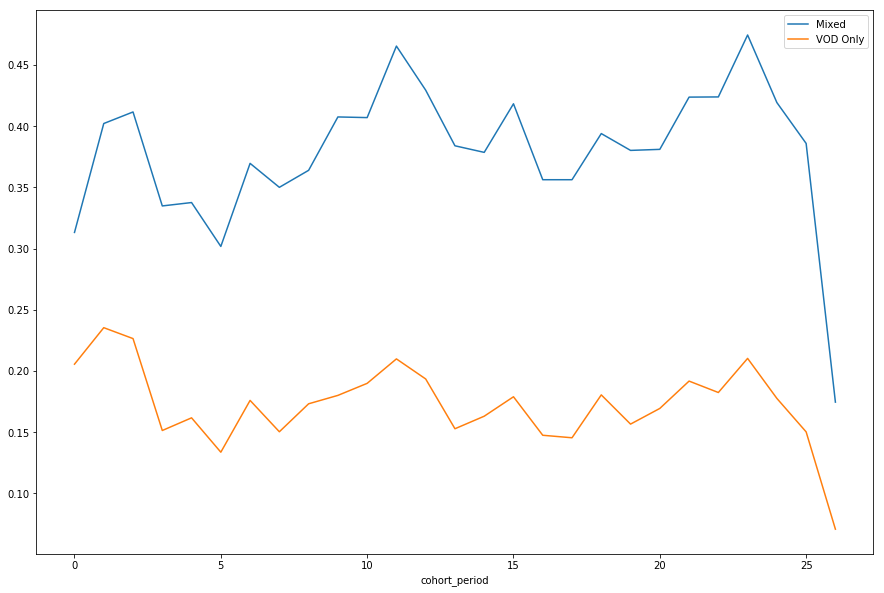

In [24]:
d = summary[summary['cohort_group' ] == '2016-01-01']

plt.figure(figsize = (15,10))
d.set_index('cohort_period', inplace=True)
d.groupby('class')['ratio'].plot(legend=True)
plt.show()